In [78]:
from ephysvibe.structures.trials_data import TrialsData
from ephysvibe.analysis import signal,layers
import numpy as np
from ephysvibe.task import task_constants
import matplotlib.pyplot as plt
import seaborn as sns


In [4]:
path = '/envau/work/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/session_struct/Riesling/lip/2023-03-06_10-32-51_Riesling_lip_e1_r1.h5'
data = TrialsData.from_python_hdf5(path)

In [79]:
trial_idx = np.where(np.logical_and(data.trial_error == 0, data.block == 1))[0]
trials_s_on = data.code_samples[
    trial_idx,
    np.where(data.code_numbers[trial_idx] == task_constants.EVENTS_B1["sample_on"])[#target_on
        1
    ],
]
t_before=500
shifts = -(trials_s_on - t_before).astype(int)
shifts = shifts[:,np.newaxis]

In [80]:
shift_lfp = TrialsData.indep_roll(data.lfp_values[trial_idx], shifts, axis=2)
shift_sp = TrialsData.indep_roll(data.sp_samples[trial_idx], shifts, axis=2)
inter_channel_distance=50
step=2
n_channels=shift_lfp.shape[1]
csd=layers.compute_csd(shift_lfp.mean(axis=0), inter_channel_distance, step=step)

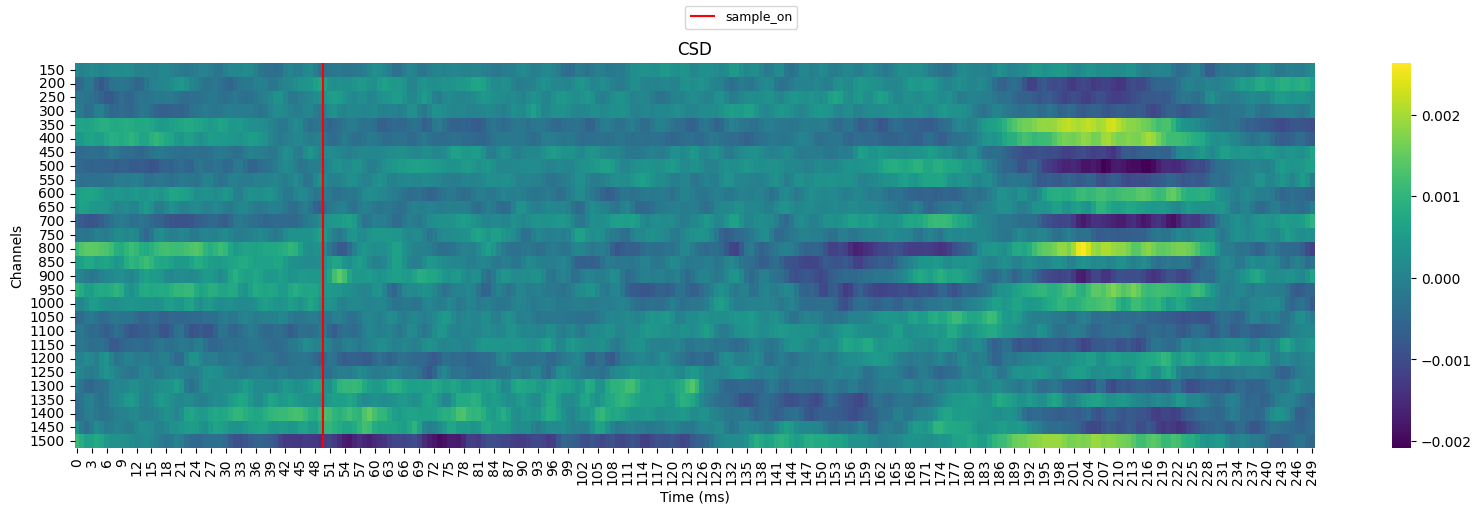

In [81]:
max_depth= inter_channel_distance*(n_channels-data.clusters_ch[0])+data.clusterdepth[0]
ch_depth = np.concatenate([np.arange(inter_channel_distance,data.clusterdepth[0],inter_channel_distance),np.arange(data.clusterdepth[0], max_depth,inter_channel_distance)])

fig, ax = plt.subplots(figsize=(20,5)) 
start_plot =  t_before-50
sns.heatmap(csd[:,start_plot:start_plot+250],cmap='viridis',ax=ax)
ax.vlines([t_before-start_plot],0,n_channels-step * 2,colors='r', label="sample_on")
fig.legend(fontsize=9,loc='upper center')
ax.set_title('CSD')
ax.set(xlabel="Time (ms)", ylabel="Channels")
ax.set_yticks(np.arange(0.5,n_channels-2*step+0.5))
a=ax.set_yticklabels(ch_depth[step:-step].astype(int), rotation=0)
#ax.set_ylabel(ch_depth[step:-step].astype(int))

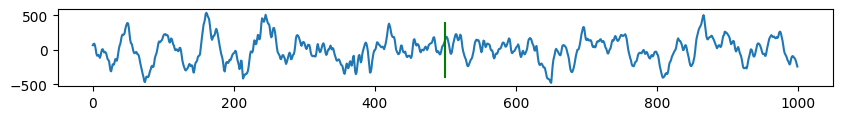

In [82]:
median_ch = np.median(shift_lfp,axis=1)
lfp_median_correction = shift_lfp-median_ch[:,np.newaxis,:]
fig,ax = plt.subplots(figsize=(10,1))
a=ax.plot(median_ch[0,:1000])
ax.vlines([t_before],-400,400,colors=['g'])

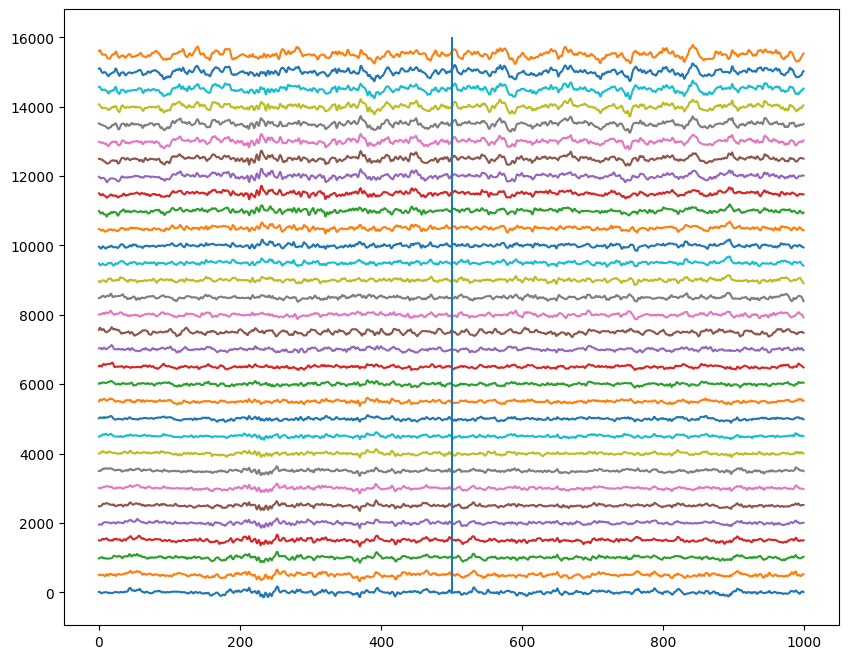

In [83]:
fig,ax = plt.subplots(figsize=(10,8))
a=ax.plot(lfp_median_correction[0,:,:1000].T+np.arange(0,32*500,500))
ax.vlines([t_before],0,32*500)

    Using multitaper spectrum estimation with 7 DPSS windows


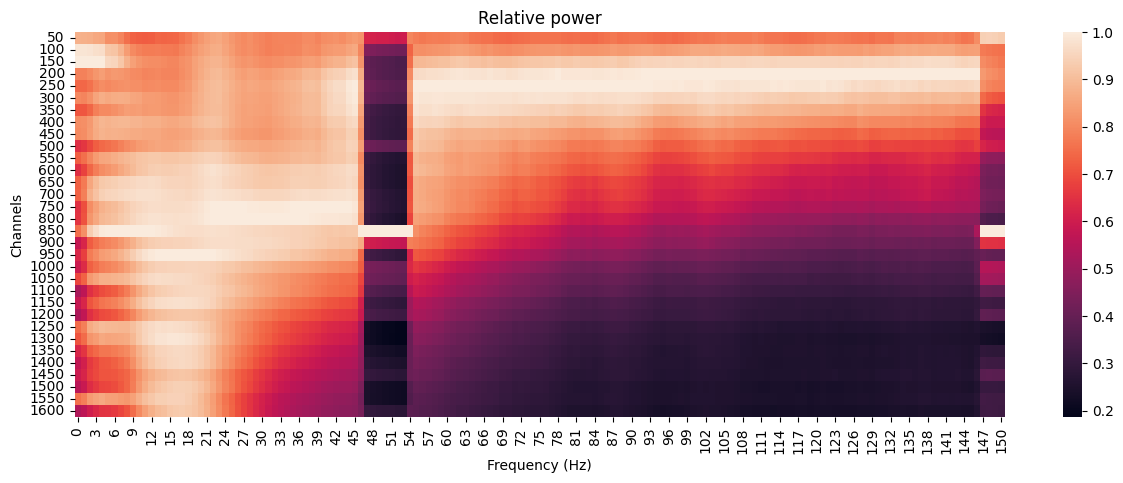

In [85]:
fmax=150
s_freq = 1000
w_size = 200
x=shift_lfp[:,:,:1000]
avg_psd,freqs = signal.compute_relative_power(x,psd_method='multitaper',fmax=150,s_freq = s_freq,w_size = w_size)
# Plot RP
_,ax = plt.subplots(figsize=(15,5))
sns.heatmap(avg_psd)
ax.set_title("Relative power")
ax.set(xlabel="Frequency (Hz)", ylabel="Channels")
ax.set_yticks(np.flip(np.arange(0.5, n_channels  + 0.5)))
ax.set_yticklabels(ch_depth.astype(int), rotation=0)
ax.invert_yaxis()
plt.show()

    Using multitaper spectrum estimation with 7 DPSS windows


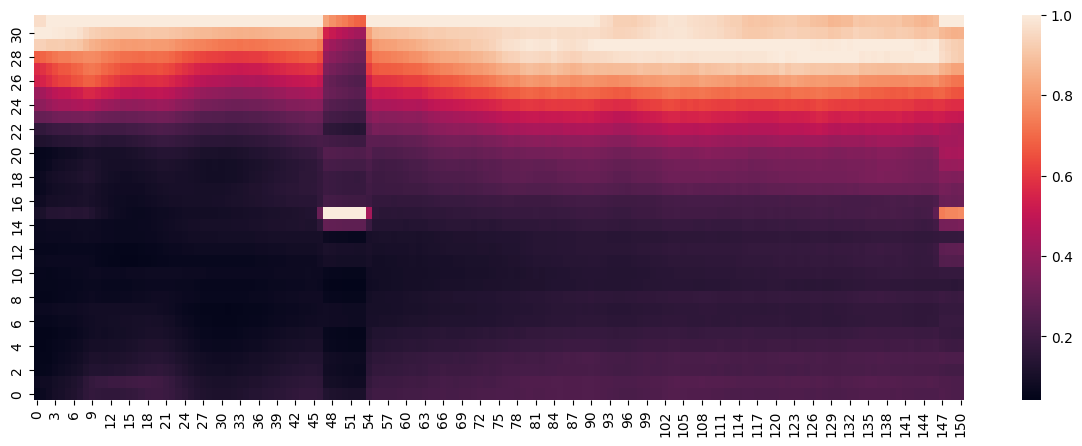

In [86]:
x=lfp_median_correction[:,:,:1000]#

avg_psd_median,freqs_median = signal.compute_relative_power(x,psd_method='multitaper',fmax=150,s_freq = s_freq,w_size = w_size)

# Plot RP
_,ax = plt.subplots(figsize=(15,5))
sns.heatmap(avg_psd_median)
ax.invert_yaxis()
plt.show()

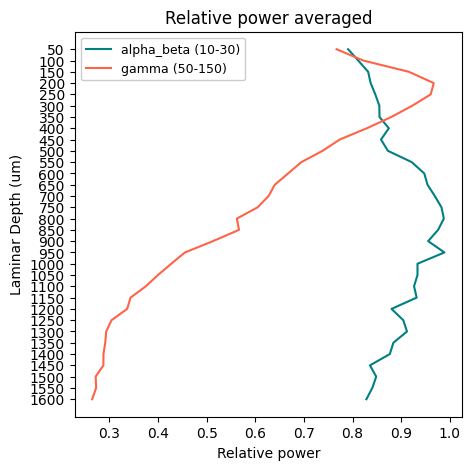

In [87]:
# compute relative power maps
rp_alpha_beta = avg_psd[:, np.where(np.logical_and(freqs > 10, freqs < 30))[0]]
rp_gamma = avg_psd[:, np.where(np.logical_and(freqs > 50, freqs < 150))[0]]
# Plot
fig,ax = plt.subplots(figsize=(5,5))
a=ax.plot(rp_alpha_beta.mean(axis=1),np.arange(0,32),label='alpha_beta (10-30)',color='teal')
a=ax.plot(rp_gamma.mean(axis=1),np.arange(0,32),label='gamma (50-150)',color='tomato')
a=ax.set_yticks(np.arange(0,32))
ax.legend(fontsize=9,columnspacing=0.5,facecolor='white', framealpha=1,loc='upper left')
ax.set_title("Relative power averaged")
ax.set(xlabel="Relative power", ylabel="Laminar Depth (um)")
ax.set_yticks(np.flip(np.arange(0, n_channels)))
a=ax.set_yticklabels(ch_depth.astype(int), rotation=0)